# Part Two

This jupyter notebook contains the code of MTH 9898 final project part 2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from scipy.stats import multivariate_normal
%matplotlib inline

## Load the Two-Moon Dataset

we first load the two-moon dataset from scikit-learn API and plot the ground truth clustering.

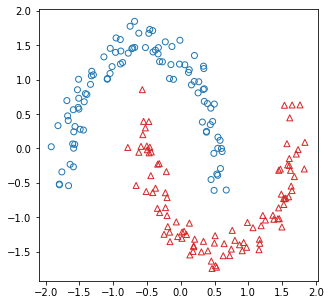

In [2]:
n_samples = 200
n_neighbors = np.ceil(np.sqrt(n_samples) / 3)
X, y = make_moons(n_samples=n_samples, random_state=42, noise=0.08)
X = StandardScaler().fit_transform(X)
fig, ax = plt.subplots(figsize=(5, 5))


def plot_cluster(
    X, y, ax, cluster_marker=["o", "^"], cluster_color=["tab:blue", "tab:red"]
):
    '''
    functions to plot the clustering based on the result
    '''
    markers = [cluster_marker[k] for k in y]
    colors = [cluster_color[k] for k in y]
    for x1, x2, c, m in zip(X[:, 0], X[:, 1], colors, markers):
        ax.scatter(x1, x2, facecolors="none", edgecolors=c, marker=m)


plot_cluster(X, y, ax)

plt.savefig('./data.png', dpi=400, bbox_inches='tight')

## LapGMM Implementation

The code below is our implementation of LapGMM with commentary in detail.

In [3]:
class LapGMM:
    """Lap Gaussian Mixture.

    Representation of a Laplacian Regularized Gaussian mixture model.
    Implementation of the paper

    He, Xiaofei, et al. "Laplacian regularized gaussian mixture model for data clustering." 
    IEEE Transactions on Knowledge and Data Engineering 23.9 (2010): 1406-1418.


    Parameters
    ----------
    n_clusters : int, default=2
        The number of mixture components/clusters.

    init : string, default='k-means',
        The initailization strategy.

    max_iter : int, default=5,
        Maximum iteration number of EM iteration.

    max_iter_NR : int, default=2000,
        Maximum iteration number of Newton-Raphson method.

    max_iter_M : int, default=500,
        Maximum iteration number of M-step.

    n_neighboors : int, default=8,
        p parameter in the nearest neighborhood graph.

    lmda : float, default=1e3,
        The sub-manifold regularization parameter.

    gamma : float, default=0.9,
        Learning rate in Newton method

    t : float, default=1,
        scale parameter in the heat kernel weighting

    weight_matrix : {'0-1', 'heat', 'dot-product'}, default='0-1',
        methods to construct weight matrix of the p-nearest-neighbors
        
    y_true : array like of shape (n_data),
        true value of clustering for accuarcy measure

    tol : float, default=1e-3
        The convergence threshold. EM iterations will stop when the
        lower bound average gain is below this threshold.

    tol_newton : float, default=1e-3
        The convergence threshold. Newton iterations will stop when the
        lower bound average gain is below this threshold.

    random_state : int, RandomState instance or None, default=None
        Controls the random seed given to the method chosen to initialize the
        parameters (see `init_params`).
        In addition, it controls the generation of random samples from the
        fitted distribution (see the method `sample`).
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    verbose : int, default=0
        Enable verbose output. 
        ==0 : silence
        <=1 : iteration info
        <=2 : debug info
        <=3 : show me the matrix

    Attributes
    ----------
    posterior : array-like of shape (n_clusters, n_data)
        the posterior probability P(k | x)

    alpha : array-like of shape (n_clusters,)
        prior probability of each cluster

    mu : array-like of shape (n_clusters, n_features)
        expectation of Gaussian distribution within each cluster

    sigma : array-like of shape (n_clusters, n_features, n_features)
        covariance matrix of Gaussian distribution within each cluster

    iter_list : array_like of shape (n_iterations)
        iteration list

    obj_list : array_like of shape (n_iterations)
        list of objective functions for model analysis purpose

    log_likelihood_list : array_like of shape (n_iterations)
        list of log likelihood functions for model analysis purpose

    R_list : array_like of shape (n_iterations)
        list of sub-manifold regularization functions for model analysis purpose

    accuracy_list : array_like of shape (n_iterations)
        list of accuracy for model analysis purpose


    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.mixture import GaussianMixture
    >>> X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
    >>> lapgmm = LapGMM(n_components=2, random_state=0).fit(X)
    >>> lapgmm.mu
    array([[10.,  2.],
           [ 1.,  2.]])
    >>> lapgmm.predict([[0, 0], [12, 3]])
    array([1, 0])

    """

    def __init__(
        self,
        n_clusters=2,
        init='k-means',
        max_iter=5,
        max_iter_NR=2000,
        max_iter_M=500,
        n_neighbors=8,
        lmda=1e3,
        gamma=0.9,
        t=1,
        weight_matrix="0-1",
        tol=1e-3,
        tol_newton=1e-3,
        verbose=1,
        random_state=None,
        only_M_step=False,
    ):
        self.k = n_clusters
        self.max_iter = int(max_iter)
        self.max_iter_NR = int(max_iter_NR)
        self.max_iter_M = int(max_iter_M)
        self.p = int(n_neighbors)
        self.lmda = lmda
        self.gamma = gamma
        self.weight_matrix = weight_matrix
        self.delta = tol
        self.delta_newton = tol_newton
        self.init = init
        self.random_state = random_state
        self.only_M_step = only_M_step

        self.iter_list = []
        self.obj_list = []
        self.log_likelihood_list = []
        self.R_list = []
        self.accuracy_list = []

        self.verbose = verbose
        self.t = t

    def initialize(self, X):
        '''
        construct the p-nearest-neighbor weight mateix
        initialize the parameter alpha, mu, sigma
        '''
        if self.verbose == 2:
            print('initializing the model')
        self.shape = X.shape
        self.m, self.d = self.shape

        # construct the nearest neighbor graph with weight matrix S
        self.S = kneighbors_graph(X, n_neighbors=self.p).toarray()

        # heat kernel weight matrix
        if self.weight_matrix == 'heat':
            for i in range(self.m):
                for j in range(self.m):
                    if self.S[i][j] == 1:
                        self.S[i][j] = np.exp(-np.dot(X[i, :] -
                                                      X[j, :], X[i, :]-X[j, :]) / self.t)
        # inner-product weight matrix
        elif self.weight_matrix == 'dot-product':
            for i in range(self.m):
                for j in range(self.m):
                    if self.S[i][j] == 1:
                        self.S[i][j] = np.dot(X[i, :], X[j, :])
        self.L = np.diag([self.S[:, i].sum() for i in range(self.m)]) - self.S
        if self.verbose >= 3:
            print('init S = \n{}\n'.format(self.S))
            print('init L = \n{}\n'.format(self.L))

        # alpha: 1xk array
        self.alpha = np.full(shape=self.k, fill_value=1 / self.k)
        # posterior matrix k x m: P(k | Xi)
        self.posterior = np.full(shape=(self.k, self.m), fill_value=1 / self.k)

        # run an initailization algo to warm up the param
        if self.init == 'k-means':

            kmeans = KMeans(n_clusters=self.k,
                            random_state=self.random_state).fit(X)
            y_pred = kmeans.labels_
        # else randomly initialize
        else:
            y_pred = np.random.randint(2, size=self.m)

        # initailize the Theta = alpha, mu, sigma using the initialization result
        self.alpha = np.array([len([y for y in y_pred if y == k]) /
                               len(y_pred) for k in range(self.k)])
        self.mu = [np.mean([x for x, y in zip(X, y_pred)
                            if y == k], axis=0) for k in range(self.k)]
        self.sigma = [np.cov(np.transpose(
            [x for x, y in zip(X, y_pred) if y == k])) for k in range(self.k)]
        if self.verbose >= 3:
            print('init alpha = \n{}\n'.format(self.alpha))
            print('init mu = \n{}\n'.format(self.mu))
            print('init sigma = \n{}\n'.format(self.sigma))

    def R(self):
        '''
        Rk in the paper
        '''
        return np.sum([self.posterior[k, :] @ self.L @ self.posterior[k, :].reshape((-1, 1)) for k in range(self.k)])

    def obj(self):
        '''
        Q function = log-likelihood - lambda * R
        '''
        log_likelihood = np.log(self.alpha @ self.posterior).sum()
        regularization = self.R()

        if self.verbose >= 2:
            print('log likelihood = {}'.format(log_likelihood))
            print('regularization = {:.6f}\n'.format(regularization))

        return log_likelihood - self.lmda * regularization

    def e_step(self, X):
        '''
        E-Step: update weights and phi holding mu and sigma constant
        '''
        self.posterior = self.predict_proba(X)

    def smooth_posterior(self):
        '''
        Use Newton-Raphson method to smooth the posterior probabilities
        '''
        if self.verbose >= 2:
            print('using Newton-Raphson method to smooth the posterior prob\n')

        new_loss = self.R()
        # this step is to make sure Newton method won't break
        # at the 0th iteration
        old_loss = new_loss + 2 * self.delta_newton
        iteration = 0

        while (abs(new_loss - old_loss) > self.delta_newton):

            S_prob = self.S / self.S.sum(axis=1).reshape((-1, 1))

            self.posterior = (1-self.gamma)*self.posterior + \
                self.gamma*(self.posterior @ S_prob.T)
            old_loss = new_loss
            new_loss = self.R()
            iteration += 1
            if self.verbose >= 2 and iteration % 50 == 0:
                print('Newton-Raphson Iter {:03}: R = {:.6f}, g(R) = {:.6f}'.format(
                    iteration, new_loss, abs(new_loss-old_loss)))

            if iteration == self.max_iter_NR:
                break

    def m_step(self, X):
        '''
        M-Step: update mu and sigma holding phi and weights constant
        '''

        # smooth the posterior using Newton-Raphson method
        self.smooth_posterior()
        # then "maximize" the log-likelihood
        self.alpha = self.posterior.sum(axis=1).T/self.m
        posterior_weight = self.posterior / \
            (self.posterior.sum(axis=1).reshape((-1, 1)))

        for k in range(self.k):
            self.mu[k] = np.sum([X[j, :] * posterior_weight[k][j]
                                 for j in range(self.m)], axis=0)
            self.sigma[k] = np.sum([posterior_weight[k][j]*((X[j, :].T-self.mu[k]).reshape(
                (-1, 1)) @ (X[j, :].T-self.mu[k]).reshape((1, self.d))) for j in range(self.m)], axis=0)
        if self.verbose >= 3:
            print('M-step alpha = \n{}\n'.format(self.alpha))
            print('M-step mu = \n{}\n'.format(self.mu))
            print('M-step sigma = \n{}\n'.format(self.sigma))

    def fit(self, X, y_true=None):
        '''
        fit method, repeatly run e-step and m-step until convergence
        or reach max itertaion
        '''
        self.initialize(X)

        for iteration in range(self.max_iter):
            # reset the gamma to be 0.9
            self.gamma = 0.9
            old_likelihood = self.obj()
            # just a experiement, what if we delete E-step
            # and only run M-step
            if self.only_M_step == False:
                self.e_step(X)

            self.m_step(X)
            new_likelihood = self.obj()
            iter_m = 1
            while (new_likelihood < old_likelihood):
                # skip the first M-loop since the init value of R = 0
                if iteration == 0:
                    break
                if self.verbose >= 2 and iter_m == 1:
                    print(
                        'M-step Iter {:d}: obj = {:.3f} old obj = {:.3f}'.format(0, new_likelihood, old_likelihood))

                # shrink the gamma
                if self.verbose >= 2:
                    print('Go to step 6 again\n')
                self.gamma = 0.9 * self.gamma
                self.m_step(X)
                new_likelihood = self.obj()
                if self.verbose >= 2:
                    print(
                        'M-step Iter {:d}: obj = {:.3f}'.format(iter_m, new_likelihood))
                iter_m += 1
                if iter_m == self.max_iter_M:
                    break

            # record obj, log-likelihood, R, accuracy in each iteration
            self.iter_list.append(iteration+1)
            self.obj_list.append(self.obj())
            self.log_likelihood_list.append(self.obj() + self.lmda * self.R())
            self.R_list.append(self.lmda * self.R())
            if (y_true != None).any():
                self.accuracy_list.append(
                ((self.predict(X) != y_true) * 1).sum() / len(y_true))
            else:
                self.accuracy_list.append(-1)

            breaker = int(self.max_iter / 15) + 1
            if self.verbose >= 1 and iteration % breaker == 0:
                print('Iter {:d}: obj = {:.3f}'.format(iteration, self.obj()))
            if abs(new_likelihood - old_likelihood) < self.delta:
                break

        print('{} iterations'.format(len(self.iter_list)))

    def predict_proba(self, X):
        '''
        return the probability density function by the GMM part
        '''
        likelihood = np.zeros((self.k, self.m))
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], cov=self.sigma[i])
            likelihood[i, :] = distribution.pdf(X)
        numerator = likelihood * self.alpha.reshape((self.k, 1))
        denominator = numerator.sum(axis=0)
        weights = numerator / denominator.reshape((1, self.m))

        return weights

    def predict(self, X):
        '''
        predict the clustering of X
        '''
        weights = self.posterior
        return np.argmax(weights, axis=0)

Now let's test the LapGMM on the two-moon dataset. we can see that LapGMM successfully identifies the moon clusters, which proves its ability to have complex decision boundaries, in contrast to linear decision boundaries of K-means, and quadratic decision boundaries of standard GMM. This is mainly contributed by the regularization term $\sum_{k}\mathcal{R}_k$.

Iter 0: obj = -194.776
Iter 4: obj = -159.317
Iter 8: obj = -156.748
Iter 12: obj = -154.414
Iter 16: obj = -153.378
Iter 20: obj = -151.574
Iter 24: obj = -149.537
Iter 28: obj = -147.862
Iter 32: obj = -147.514
Iter 36: obj = -146.418
Iter 40: obj = -146.086
Iter 44: obj = -145.164
Iter 48: obj = -144.230
50 iterations
0.995


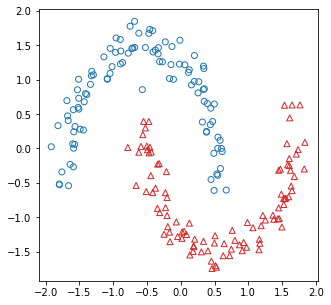

In [5]:
# LapGMM
lapgmm = LapGMM(random_state=42, verbose=1,
                max_iter=50, tol=1e-6, tol_newton=1e-6, lmda=1e2,
                n_neighbors=n_neighbors, weight_matrix='dot-product')
lapgmm.fit(X, y_true=y)
y_pred = lapgmm.predict(X)

# accuracy
lapgmm_accuracy = ((y_pred != y) * 1).sum() / len(y)
print(lapgmm_accuracy)

# plot
fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster(X, 1-y_pred, ax)

plt.savefig('./LapGMM.png', dpi=400, bbox_inches='tight')

To further see how LapGMM improves its estimation throughout iterations, we plotted the evolution of objective function $\mathcal{L}(\Theta)$, log-likelihood function $\mathcal{Q}(\Theta, \Theta^{n-1})$, regularization term $\sum_{k}\mathcal{R}_k$ and accuracy, as shown in Figure below.

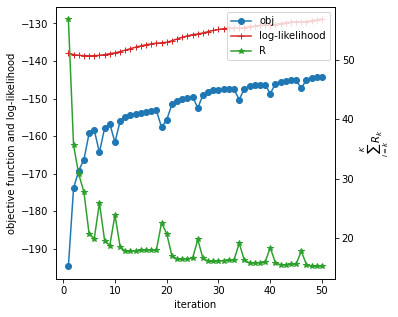

In [6]:
# plot obj, log-likelihood, R ~ iteration
fig, ax = plt.subplots(figsize=(5, 5))
lns1 = ax.plot(lapgmm.iter_list, lapgmm.obj_list,
               '-o', label='obj', color='tab:blue')
lns2 = ax.plot(lapgmm.iter_list, lapgmm.log_likelihood_list,
               '-+', label='log-likelihood', color='tab:red')
ax2 = ax.twinx()
lns3 = ax2.plot(lapgmm.iter_list, lapgmm.R_list,
                '-*', label='R', color='tab:green')
# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper right')
ax.set_xlabel('iteration')
ax.set_ylabel('objective function and log-likelihood')
ax2.set_ylabel('$\sum_{i=k}^K R_k$')
plt.savefig('./loss.png', dpi=400, bbox_inches='tight')

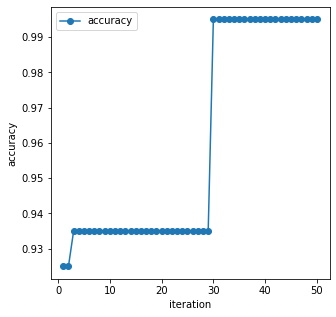

In [7]:
# plot accuracy ~ iteration
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(lapgmm.iter_list, lapgmm.accuracy_list, '-o', label='accuracy')
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')
ax.legend(loc=0)
plt.savefig('./acc.png', dpi=400, bbox_inches='tight')

Adam's code with comment
Adam's code with comment
Adam's code with comment
Adam's code with comment
Adam's code with comment
Adam's code with comment
Adam's code with comment
Adam's code with comment
Adam's code with comment

## Other clustering models: GMM, K-means, PCA + K-means, NMF

LapGMM outperforms other clustering algorithms, with “good” hyper-parameters. From Figures below, we can also see that LapGMM generally outperforms other clustering algorithms, including K-means, PCA + K-means, NMF and standard GMM. 

In [8]:
def plot_decision_boundary(X, clf, ax):
    '''
    function to plot the decision boundary of clf
    clf must implement the correct predict() method
    '''
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    cm = ListedColormap(['white', 'silver'])
    ax.imshow(Z, interpolation="nearest",
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=cm,
              aspect="auto", origin="lower")
    


The quadratic decision boundary of GMM limited the clustering ability in two-moon dataset.

0.865


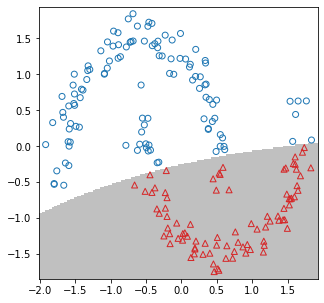

In [9]:
from matplotlib.colors import ListedColormap

# GMM
gmm = GaussianMixture(n_components=2, random_state=17,
                      init_params='random', max_iter=100)
gmm.fit(X)
y_pred_gmm = gmm.predict(X)

# accuracy
gmm_accuracy = ((y_pred_gmm != y) * 1).sum() / len(y)
if gmm_accuracy < 0.5:
    gmm_accuracy = 1-gmm_accuracy
print(gmm_accuracy)

# plot
fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster(X, y_pred_gmm, ax)
plot_decision_boundary(X, clf=gmm, ax=ax)

plt.savefig('./gmm.png', dpi=400, bbox_inches='tight')

The linear decision boundary of k-means limited the clustering ability in two-moon dataset.

0.835


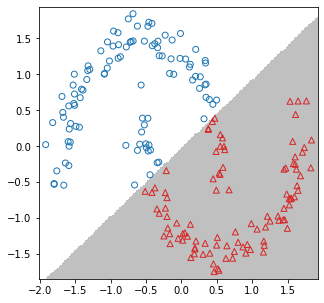

In [10]:
# K-means
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)
y_pred_kmeans = kmeans.labels_

# accuracy
kmeans_accuracy = ((y_pred_kmeans != y) * 1).sum() / len(y)
if kmeans_accuracy < 0.5:
    kmeans_accuracy = 1 - kmeans_accuracy
print(kmeans_accuracy)

# plot
fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster(X, y_pred_kmeans, ax)
plot_decision_boundary(X, clf=kmeans, ax=ax)

plt.savefig('./kmeans.png', dpi=400, bbox_inches='tight')

Doing PCA won't help to improve the boundary

0.835


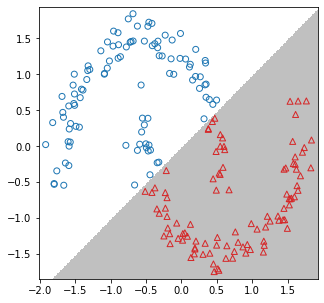

In [11]:
# PCA + K-means
from sklearn.pipeline import Pipeline

pca = PCA(n_components=1)
pca_kmeans = Pipeline(
    [('pca', pca), ('kmeans', KMeans(n_clusters=2, random_state=0))])
pca_kmeans.fit(X)
y_pred_pca_kmeans = pca_kmeans.predict(X)

# accuracy
pca_kmeans_accuracy = ((y_pred_pca_kmeans != y) * 1).sum() / len(y)
if pca_kmeans_accuracy < 0.5:
    pca_kmeans_accuracy = 1 - pca_kmeans_accuracy
print(pca_kmeans_accuracy)

# plot
fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster(X, y_pred_pca_kmeans, ax)
plot_decision_boundary(X, clf=pca_kmeans, ax=ax)

plt.savefig('./pca-kmeans.png', dpi=400, bbox_inches='tight')

Although NMF doesn't have a clear decision boundary, it models each cluster as a linear combination of the data points. So it's difficult to cluster the ambient space.

/Users/allen/miniforge3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


0.825


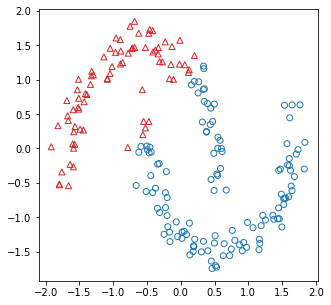

In [12]:
# transform X to positive values
min_max = MinMaxScaler()
min_max.fit(X)
X_transformed = min_max.transform(X)
# X_transformed = X + 2

# NMF
nmf = NMF(n_components=2, init='random', random_state=0)
U = nmf.fit_transform(X_transformed)
V = nmf.components_

# normalize U and V
U_norm = normalize(U)
V_norm = normalize(V)

# assign clusters
y_pred_nmf = np.argmax(U_norm, axis=1)


# accuracy
nmf_accuracy = ((y_pred_nmf != y) * 1).sum() / len(y)
print(nmf_accuracy)

# plot
fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster(X, y_pred_nmf, ax)

plt.savefig('./nmf.png', dpi=400, bbox_inches='tight')

## Parameter sensitivity

In addition, the performance of LapGMM is not affected by changes in $\lambda$, but largely affected by changes in $p$. We generated the two-moon dataset with $m = 200$. 

In [13]:
# lmda
lmda_list = [0, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
accuracy_lmda_list = []

for lmda in lmda_list:
    lapgmm_lmda = LapGMM(random_state=42, verbose=0,
                         max_iter=50, tol=1e-6, tol_newton=1e-6, lmda=lmda,
                         n_neighbors=n_neighbors, weight_matrix='dot-product')
    lapgmm_lmda.fit(X, y_true=y)
    y_pred_lmda = lapgmm_lmda.predict(X)
    accuracy_lmda_list.append(((y_pred_lmda != y) * 1).sum() / len(y))

print(accuracy_lmda_list)

50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
[0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995]


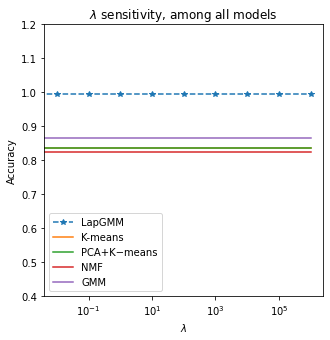

In [14]:
# plot lmda sensitivity, among all models
plt.figure(figsize=(5, 5))
plt.plot(lmda_list, accuracy_lmda_list, '--*', label='LapGMM')
plt.plot(lmda_list, [kmeans_accuracy] * len(lmda_list), label='K-means')
plt.plot(lmda_list, [pca_kmeans_accuracy] *
         len(lmda_list), label='PCA+K−means')
plt.plot(lmda_list, [nmf_accuracy] * len(lmda_list), label='NMF')
plt.plot(lmda_list, [gmm_accuracy] * len(lmda_list), label='GMM')
plt.title('$\lambda$ sensitivity, among all models')
plt.ylabel('Accuracy')
plt.xlabel('$\lambda$')

plt.ylim(0.4, 1.2)
plt.xscale('log')
plt.legend(loc=0)
plt.savefig('./lambda.png', dpi=400, bbox_inches='tight')

A rule of thumb is that $p = \sqrt{m} \approx 14$; while in practice, we found that $p = \lceil\sqrt{m}/3\rceil = 5$ usually worked best. If $p$ is too small, the weight matrix $S$ becomes too sparse, then we’ll update $\mathbb{P}(k | \mathbf{x}_i)$ too efficiently to quickly find the global minimum of $\sum_k\mathcal{R}_k$. 

In [15]:
p_list = [1, 2, 3, 5, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21]
accuracy_p_list = []

for p in p_list:
    lapgmm_p = LapGMM(random_state=42, verbose=0,
                      max_iter=50, tol=1e-6, tol_newton=1e-6, lmda=1e2,
                      n_neighbors=p, weight_matrix='dot-product')
    lapgmm_p.fit(X, y_true=y)
    y_pred_p = lapgmm_p.predict(X)
    accuracy_p_list.append(((y_pred_p != y) * 1).sum() / len(y))

print(accuracy_p_list)

50 iterations
50 iterations
32 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
[0.84, 0.87, 0.845, 0.995, 0.995, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


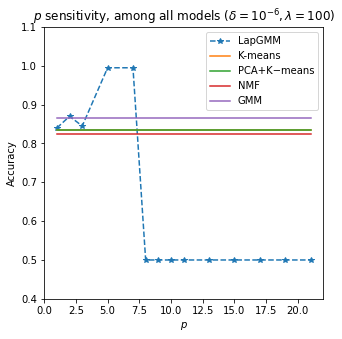

In [16]:
# plot p sensitivity, among all models
plt.figure(figsize=(5, 5))
plt.plot(p_list, accuracy_p_list, '--*', label='LapGMM')
plt.plot(p_list, [kmeans_accuracy] * len(p_list), label='K-means')
plt.plot(p_list, [pca_kmeans_accuracy] * len(p_list), label='PCA+K−means')
plt.plot(p_list, [nmf_accuracy] * len(p_list), label='NMF')
plt.plot(p_list, [gmm_accuracy] * len(p_list), label='GMM')
plt.title('$p$ sensitivity, among all models ($\delta=10^{-6}, \lambda=100$)')
plt.ylabel('Accuracy')
plt.xlabel('$p$')
plt.ylim(0.4, 1.1)
plt.legend(loc=0)
plt.savefig('./p.png', dpi=400, bbox_inches='tight')

50 iterations
50 iterations
28 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
50 iterations
30 iterations
50 iterations
50 iterations


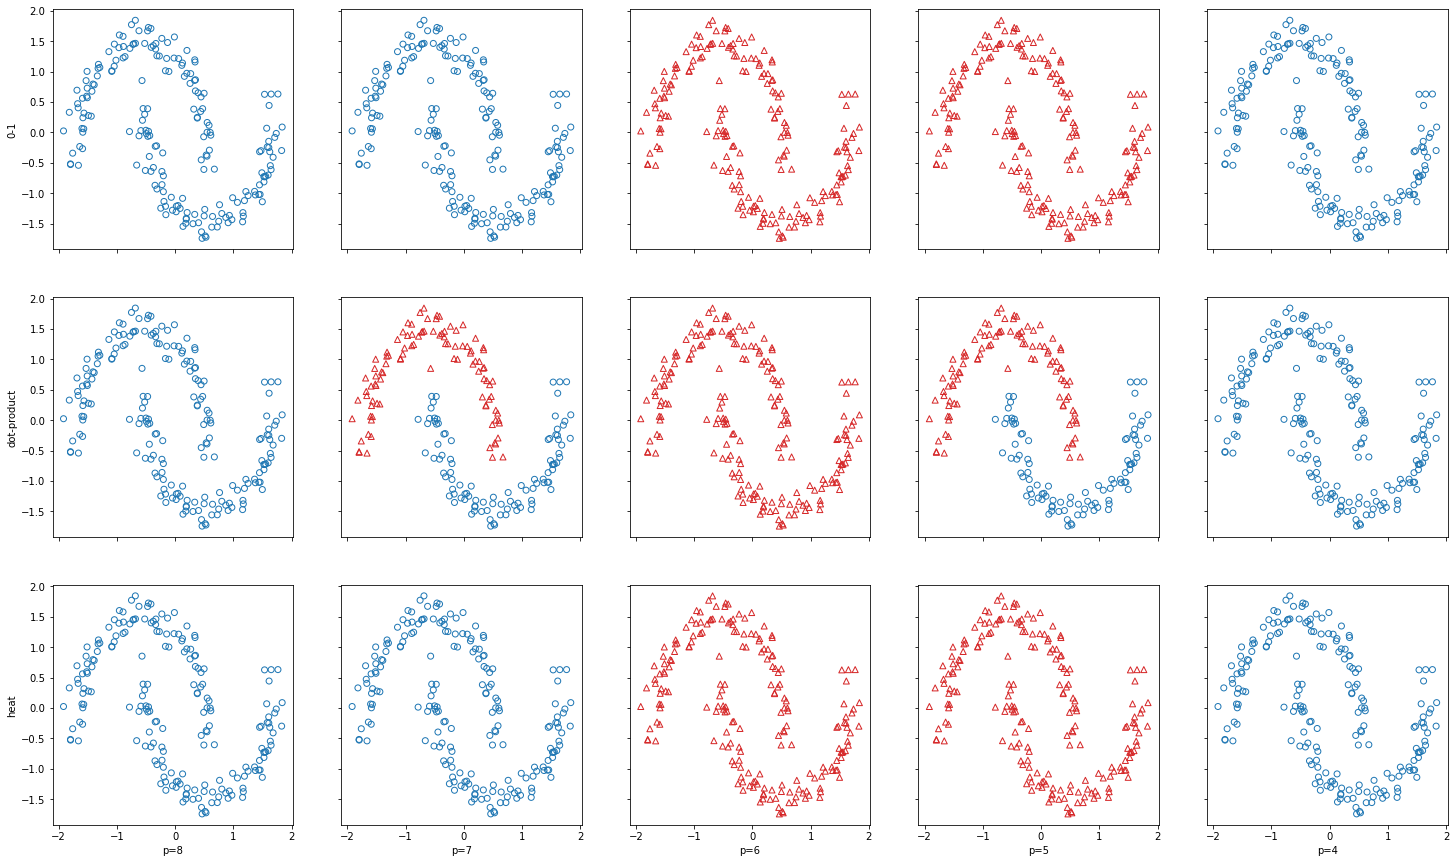

In [19]:
# Examine sensitivity to p-neighbors for each weight matrix type
fig, ax = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(25, 15))
mat_type = ['0-1','dot-product','heat']
cluster_marker=["o", "^"]
cluster_color=["tab:blue", "tab:red"]
for mat_idx in range(len(mat_type)):
    for p in range(8,3,-1):
        lapgmm = LapGMM(random_state=42, verbose=0,
                        max_iter=50, tol=1e-6, tol_newton=1e-6, lmda=1e2, n_neighbors=p, weight_matrix=mat_type[mat_idx])
        lapgmm.fit(X,y)
        y_pred = lapgmm.predict(X)
        
        markers = [cluster_marker[k] for k in y_pred]
        colors = [cluster_color[k] for k in y_pred]
        for x1, x2, c, m in zip(X[:, 0], X[:, 1], colors, markers):
            ax[mat_idx][8-p].scatter(x1, x2, facecolors="none", edgecolors=c, marker=m)
        if mat_type[mat_idx]=='heat':
            ax[mat_idx][8-p].set_xlabel('p='+str(p))
        if p==8:
            ax[mat_idx][8-p].set_ylabel(mat_type[mat_idx])

16 iterations
31 iterations
120 iterations
120 iterations
120 iterations
9 iterations
32 iterations
57 iterations
82 iterations
107 iterations
16 iterations
24 iterations
120 iterations
120 iterations
120 iterations


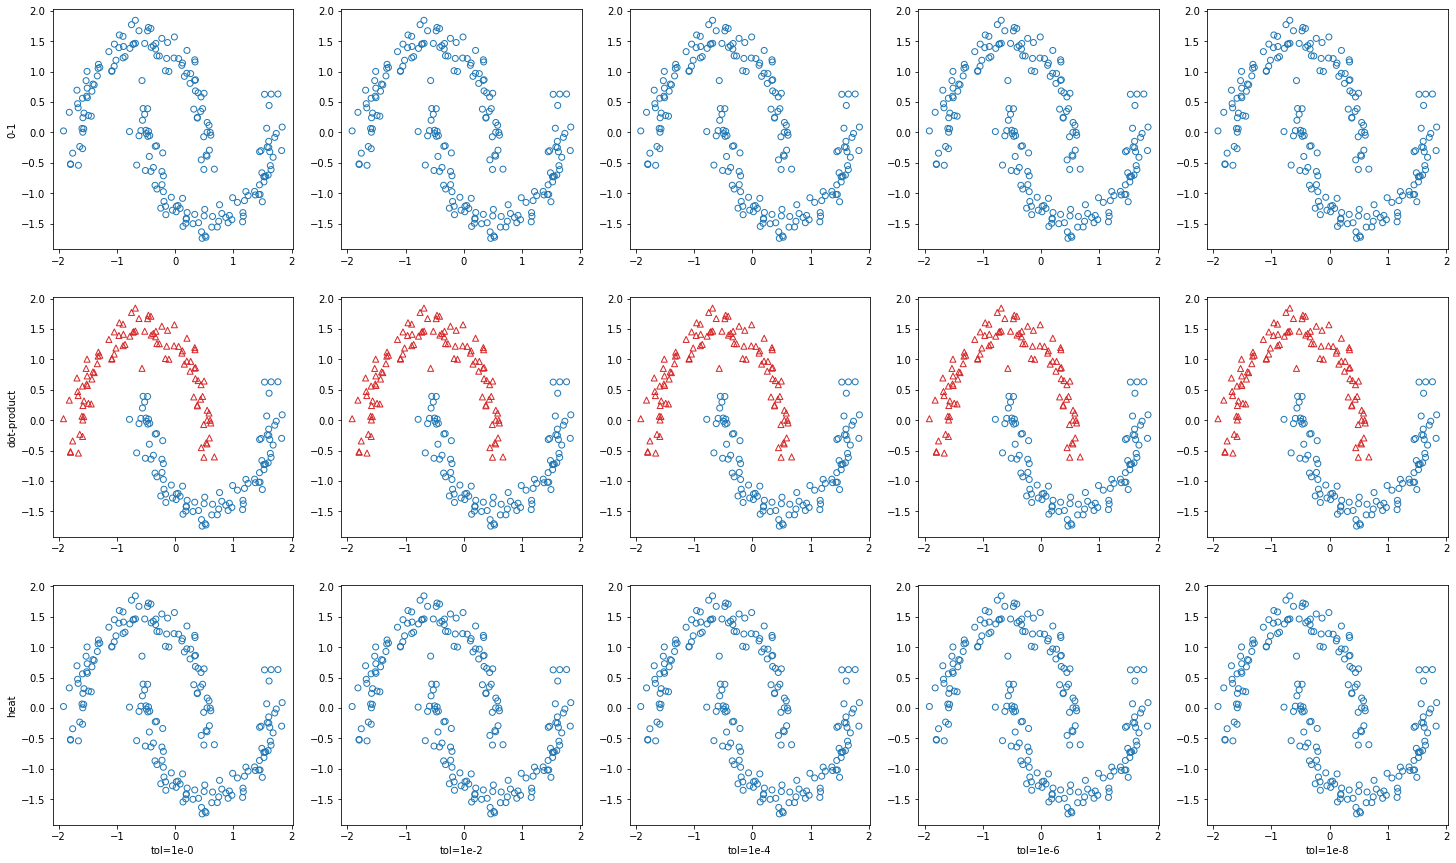

In [20]:
# Examine sensitivity to tolerance for LapGMM algorithm for each weight matrix type
fig, ax = plt.subplots(3, 5, figsize=(25, 15))
for mat_idx in range(len(mat_type)):
    for tol_scale in range(0,10,2):
        lapgmm = LapGMM(random_state=42, verbose=0, max_iter=120, tol_newton=1e-6,
                        tol=10**-tol_scale, lmda=1e2, n_neighbors=7, weight_matrix=mat_type[mat_idx])
        lapgmm.fit(X,y)
        y_pred = lapgmm.predict(X)
        
        markers = [cluster_marker[k] for k in y_pred]
        colors = [cluster_color[k] for k in y_pred]
        for x1, x2, c, m in zip(X[:, 0], X[:, 1], colors, markers):
            ax[mat_idx][tol_scale//2].scatter(x1, x2, facecolors="none", edgecolors=c, marker=m)
        if mat_type[mat_idx]=='heat':
            ax[mat_idx][tol_scale//2].set_xlabel('tol=1e-'+str(tol_scale))
        if tol_scale==0:
            ax[mat_idx][tol_scale//2].set_ylabel(mat_type[mat_idx])